<img align="center" src="logo.png" alt="drawing"/>

# Urban Sounds Classification

## Koç Holding Derin Öğrenme Bootcamp

    
- Bu projede “UrbanSounds8K” veri setini kullanarak şehirlerde duyulan seslerin sınıflandırılmasıyla ilgili bir proje yapacağız. Bu projede hedefimiz, derin öğrenme algoritmalarını kullanarak yapay zeka modeli hazırlamaktır.

- 42.Grup 🦊 - hellp-world

### Content:
    
0. [Veri Setinin İncelenmesi](#0)
1. [Spectrogram Oluşturma](#1)
2. [Önişleme](#2)
3. [Model Hazırlanması ve Eğitimi](#3)

<a id = "0"></a><br>

# 0.Veri Setinin İncelenmesi

Bu veri seti, 10 sınıftan oluşan kentsel seslerin, 8732 etiketli ses alıntısını içermektedir. Sesli dosyalara ek olarak, her bir ses ile ilgili meta verileri içeren bir CSV dosyası da vardır.

Sınıflar şu şekildedir:
* air_conditioner(0), 
* car_horn(1), 
* children_playing(2), 
* dog_bark(3), 
* drilling(4), 
* enginge_idling(5), 
* gun_shot(6), 
* jackhammer(7), 
* siren(8),
* street_music(9)

CVS dosyasında bulunanlar ise şu şekildedir:
* slice_file_name	=> Ses dosyasının adı.**[fsID]-[classID]-[occurrenceID]-[sliceID].wav** şeklinde isimlendirilir.
* fsID => Alıntının alındığı dilimin Freesound ID'sini ifade eder.
* start => Freesound kaydındaki dilimin başlangıç ​​zamanını ifade eder.	
* end => Freesound kaydındaki dilimin bitiş zamanını ifade eder.
* salience => Sesin belirginlik derecesini ifade eder. 
   * 1:ön plan, 
   * 2:arka plan.
* fold => Dosya numarasını ifade eder. (1-10)
* classID => Ses sınıfının sayısal tanımlayıcısıdır. Yukarıda sınıf isimlerinin yanında belirtilen rakamlar classID'sini ifade eder.(0-9)
* class => sınıf adını ifade eder.	

Veri seti ile ilgili daha fazla detay için https://urbansounddataset.weebly.com/ adresine göz atabilirsiniz.


In [1]:
import keras # Sinir ağı kütüphanesi

import IPython.display 
import librosa # Ses analizi için kullanılır
import librosa.display

import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Veriyi içeri aktaralım
df = pd.read_csv("UrbanSound8K.csv")
df.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
# Veriyi daha iyi tanımak için veri hakkında bilgi edinelim
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


In [4]:
# Veri setinindeki istatistiksel değerlere bakalım
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fsID,8732.0,116033.493816,57991.017218,344.000000,69942.250000,118279.000000,166942.000000,209992.000000
start,8732.0,38.645409,74.292126,0.000000,3.000000,10.376492,35.131372,600.125356
end,8732.0,42.253312,74.369669,0.105962,6.839398,14.000000,38.866979,604.125356
salience,8732.0,1.347000,0.476043,1.000000,1.000000,1.000000,2.000000,2.000000
fold,8732.0,5.385937,2.846820,1.000000,3.000000,5.000000,8.000000,10.000000
classID,8732.0,4.592877,2.894544,0.000000,2.000000,4.000000,7.000000,9.000000


In [5]:
# Class sütununda bulunan değerleri listeleyelim
df['class'].unique()

array(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
       'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
       'drilling'], dtype=object)

In [6]:
df.shape

(8732, 8)

In [7]:
# Class sütununda bulunan değerleri sayalım
df['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [8]:
# Veri setinde boş değer var mı kontrol edelim
df.isnull().values.any()

False

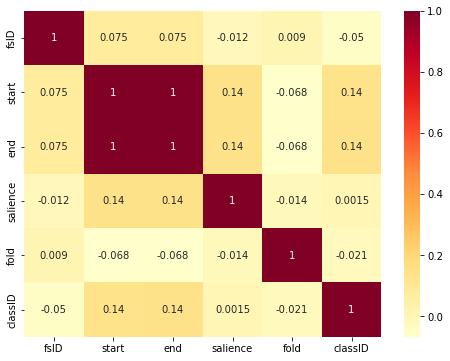

In [9]:
# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(),annot=True,cmap='YlOrRd')
plt.show()

In [10]:
import glob # Belirli bir klasör içindeki dosyaları listelememize yardımcı olan bir modül
import soundfile as sf # Ses sinyalleri içeren NumPy dizilerini oynatır

# Veri setindeki dosyalardan birini seçip listeyelim
fold1 = glob.glob('fold1\*')

In [11]:
class_map = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling', 
                 '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,0,air_conditioner
1,1,car_horn
2,2,children_playing
3,3,dog_bark
4,4,drilling
5,5,engine_idling
6,6,gun_shot
7,7,jackhammer
8,8,siren
9,9,street_music


In [12]:
# Oluşturduğumuz class_map'i ve seçtiğimiz dosyadan bir sample oluşturalım
samples = [(class_map[label], [f for f in fold1 if f.split('-')[1] == label][0]) 
           for label in class_map.keys()]

In [13]:
# Ses verilerini almak için bir fonksiyon oluşturalım
def get_sound_data(path, sr=22050):
    data, fsr = sf.read(path)
    data_22k = librosa.resample(data.T, fsr, sr)
    if len(data_22k.shape) > 1:
        data_22k = np.average(data_22k, axis=0)
    return data_22k, sr
sample_data = [(sample[0], get_sound_data(sample[1])) for sample in samples]
[(sample[0], sample[1][0].shape) for sample in sample_data]

[('air_conditioner', (44982,)),
 ('car_horn', (5513,)),
 ('children_playing', (88200,)),
 ('dog_bark', (88200,)),
 ('drilling', (88200,)),
 ('engine_idling', (88200,)),
 ('gun_shot', (57551,)),
 ('jackhammer', (88200,)),
 ('siren', (88200,)),
 ('street_music', (88200,))]

In [14]:
for data in sample_data:
    print(data[0], ':')
    IPython.display.display(IPython.display.Audio(data=data[1][0], rate=data[1][1]))

air_conditioner :


car_horn :
children_playing :


dog_bark :


drilling :


engine_idling :


gun_shot :


jackhammer :


siren :


street_music :


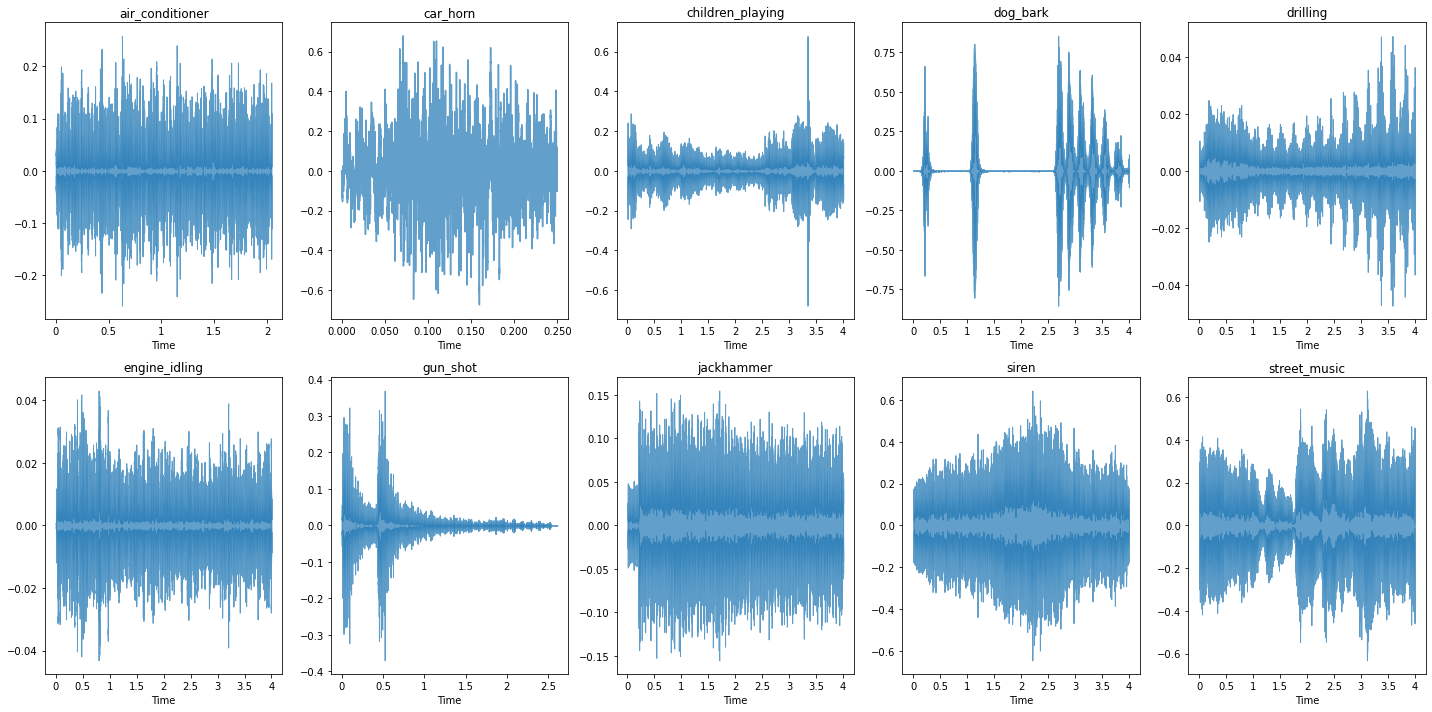

In [15]:
i = 1
fig = plt.figure(figsize=(20,10))
for item in sample_data:
    plt.subplot(2, 5, i)
    librosa.display.waveshow(item[1][0], sr=item[1][1], alpha=0.7)
    plt.title(item[0])
    i += 1
plt.tight_layout()

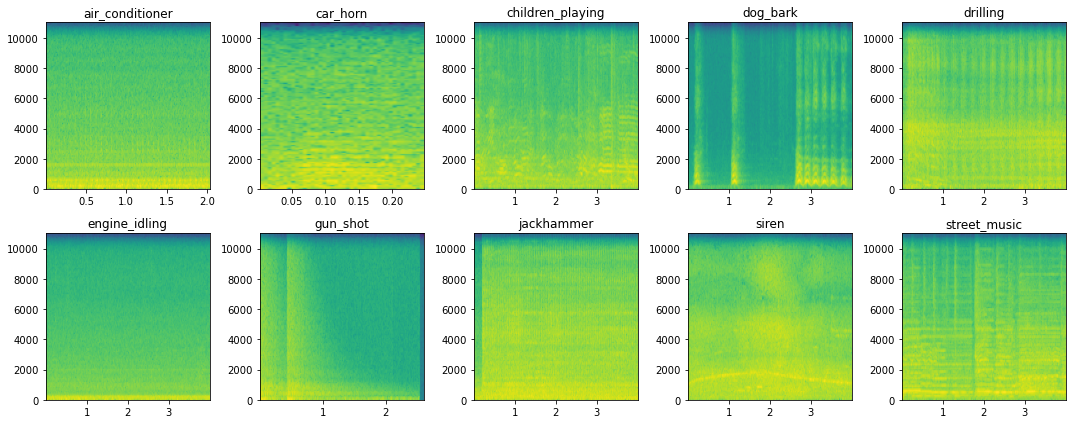

In [16]:
from matplotlib.pyplot import specgram
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    specgram(item[1][0], Fs=item[1][1])
    plt.title(item[0])
    i += 1
plt.tight_layout()

In [17]:
# Örnek spektrogramlar
y, sr = librosa.load('fold6/135160-8-0-0.wav',duration=2.97)
ps = librosa.feature.melspectrogram(y=y,sr=sr)
ps.shape

(128, 128)

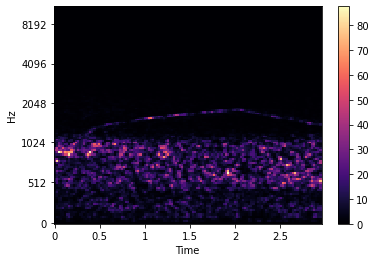

In [18]:
librosa.display.specshow(ps, y_axis = 'mel', x_axis='time')
plt.colorbar()
plt.show()

In [19]:
# Örnek spektrogramlar
y, sr = librosa.load('fold1/134717-0-0-19.wav',duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 128)

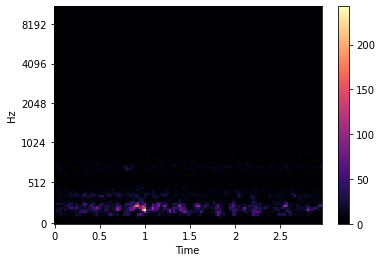

In [20]:
librosa.display.specshow(ps, y_axis='mel',x_axis='time')
plt.colorbar()
plt.show()

In [21]:
# Örnek spektrogramlar
y, sr = librosa.load('fold5/100852-0-0-0.wav',duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 128)

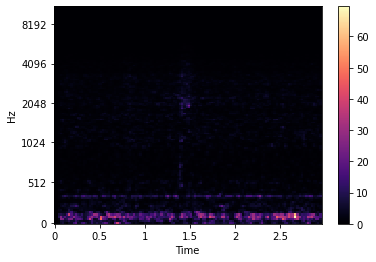

In [22]:
librosa.display.specshow(ps, y_axis='mel',x_axis='time')
plt.colorbar()
plt.show()

In [23]:
# Örnek spektrogramlar
y, ar = librosa.load('fold9/137815-4-0-0.wav',duration=2.97)
ps = librosa.feature.melspectrogram(y=y,sr=sr)
ps.shape

(128, 128)

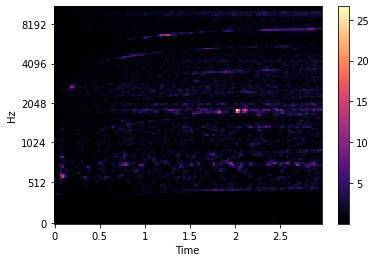

In [24]:
librosa.display.specshow(ps, y_axis='mel',x_axis='time')
plt.colorbar()
plt.show()

<a id = "1"></a><br>
#  1. Spectrogram Oluşturma

* **Mel** frekans ölçeği, insan kulağının ses frekanslarındaki değişimi algılayışını gösteren bir ölçektir. MFCC(Mel-Frequency Cepstral Coefficients), ses sinyalinin kısa zamanlı güç spektrumunun Mel ölçeği üzerindeki ifadesidir.
* **Chroma** frekansı ölçeği,müzikal oktavının 12 farklı yarı tonunu(chroma) temsil eden 12 parçanın belirtildiği ses için güçlü bir sunumudur.

In [25]:
def create_melspectrum(y):
    spec = librosa.feature.melspectrogram(y=y)
    spec_conv = librosa.amplitude_to_db(spec,ref=np.max)
    return spec_conv

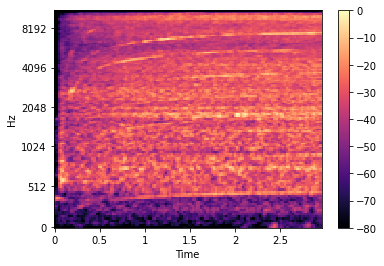

In [26]:
librosa.display.specshow(create_melspectrum(y), y_axis='mel',x_axis='time')
plt.colorbar()
plt.show()

In [27]:
def create_chromaspectrum(y):
    spec = librosa.feature.chroma_stft(y=y)
    spec_conv = librosa.amplitude_to_db(spec,ref=np.max)
    return spec_conv

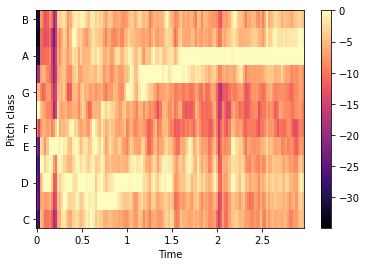

In [28]:
librosa.display.specshow(create_chromaspectrum(y), y_axis='chroma',x_axis='time')
plt.colorbar()
plt.show()

<a id = "2"></a><br>
# 2. Önişleme

- Bize verilen proje dokümanında yer alan **"Spectrograms"** dosyasını projeye dahil edelim ve oradaki verileri inceleyelim.

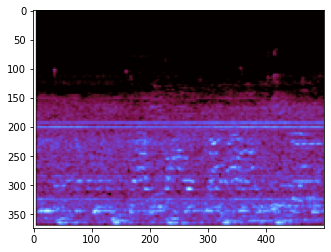

In [29]:
import cv2 # bir görüntü işleme kütüphanesi

# spectroms dosyasından rastgele bir kaç görüntü seçip inceleyelim.
img = cv2.imread("spectrograms/0/13230-0-0-1.png")
plt.imshow(img)
plt.show()

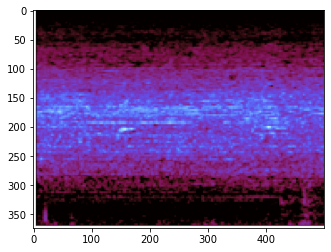

In [30]:
img1 = cv2.imread("spectrograms/4/103199-4-2-11.png")
plt.imshow(img1)
plt.show()

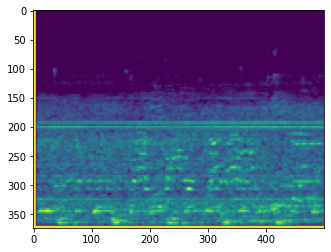

In [31]:
# openCv kütüphanesini kullanarak yukarıda rastgele seçilen spektrum görüntülerini grayscale dönüştürelim.
img = cv2.imread('spectrograms/0/13230-0-0-1.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)
plt.show()

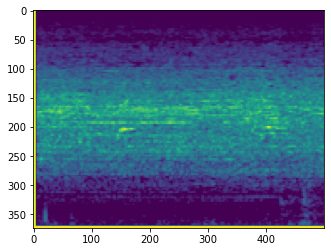

In [32]:
img1 = cv2.imread('spectrograms/4/103199-4-2-11.png')
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)
plt.show()

In [33]:
# Bu kod satırı sayesinde spektrum görüntülerine grayscale dönüşümü yapılarak yeni görüntüler dosyalandı.

import os # os,işletim sistemlerinin temel ihtiyaçlarına destek sağlar
from os import listdir,makedirs
from os.path import isfile,join

path = r'C:/Users/USER/Desktop/spectrograms/0' # Kaynak dosya
dstpath = r'C:/Users/USER/Desktop/grayscale/0' # Hedef dosya
try:
    makedirs(dstpath)
except:
    print ("Directory already exist, images will be written in same folder")

files = list(filter(lambda f: isfile(join(path,f)), listdir(path)))
for image in files:
    try:
        img = cv2.imread(os.path.join(path,image))
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        dstPath = join(dstpath,image)
        cv2.imwrite(dstPath,gray)
    except:
        print ("0 is not converted".format(image))
for fil in glob.glob("*.png"):
    try:
        image = cv2.imread(fil) 
        gray_image = cv2.cvtColor(os.path.join(path,image), cv2.COLOR_BGR2GRAY) # greyscale dönüştür
        cv2.imwrite(os.path.join(dstpath,fil),gray_image)
    except:
        print('0 is not converted')


Directory already exist, images will be written in same folder
0 is not converted


In [34]:
path = r'C:/Users/USER/Desktop/spectrograms/1' 
dstpath = r'C:/Users/USER/Desktop/grayscale/1' 
try:
    makedirs(dstpath)
except:
    print ("Directory already exist, images will be written in same folder")

files = list(filter(lambda f: isfile(join(path,f)), listdir(path)))
for image in files:
    try:
        img = cv2.imread(os.path.join(path,image))
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        dstPath = join(dstpath,image)
        cv2.imwrite(dstPath,gray)
    except:
        print ("1 is not converted".format(image))
for fil in glob.glob("*.png"):
    try:
        image = cv2.imread(fil) 
        gray_image = cv2.cvtColor(os.path.join(path,image), cv2.COLOR_BGR2GRAY)
        cv2.imwrite(os.path.join(dstpath,fil),gray_image)
    except:
        print('1 is not converted')


Directory already exist, images will be written in same folder
1 is not converted


In [35]:
path = r'C:/Users/USER/Desktop/spectrograms/2'
dstpath = r'C:/Users/USER/Desktop/grayscale/2'
try:
    makedirs(dstpath)
except:
    print ("Directory already exist, images will be written in same folder")

files = list(filter(lambda f: isfile(join(path,f)), listdir(path)))
for image in files:
    try:
        img = cv2.imread(os.path.join(path,image))
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        dstPath = join(dstpath,image)
        cv2.imwrite(dstPath,gray)
    except:
        print ("2 is not converted".format(image))
for fil in glob.glob("*.png"):
    try:
        image = cv2.imread(fil) 
        gray_image = cv2.cvtColor(os.path.join(path,image), cv2.COLOR_BGR2GRAY) 
        cv2.imwrite(os.path.join(dstpath,fil),gray_image)
    except:
        print('2 is not converted')


Directory already exist, images will be written in same folder
2 is not converted


In [36]:
path = r'C:/Users/USER/Desktop/spectrograms/3'
dstpath = r'C:/Users/USER/Desktop/grayscale/3'
try:
    makedirs(dstpath)
except:
    print ("Directory already exist, images will be written in same folder")

files = list(filter(lambda f: isfile(join(path,f)), listdir(path)))
for image in files:
    try:
        img = cv2.imread(os.path.join(path,image))
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        dstPath = join(dstpath,image)
        cv2.imwrite(dstPath,gray)
    except:
        print ("3 is not converted".format(image))
for fil in glob.glob("*.png"):
    try:
        image = cv2.imread(fil) 
        gray_image = cv2.cvtColor(os.path.join(path,image), cv2.COLOR_BGR2GRAY) 
        cv2.imwrite(os.path.join(dstpath,fil),gray_image)
    except:
        print('3 is not converted')


Directory already exist, images will be written in same folder
3 is not converted


In [37]:
path = r'C:/Users/USER/Desktop/spectrograms/4' 
dstpath = r'C:/Users/USER/Desktop/grayscale/4' 
try:
    makedirs(dstpath)
except:
    print ("Directory already exist, images will be written in same folder")

files = list(filter(lambda f: isfile(join(path,f)), listdir(path)))
for image in files:
    try:
        img = cv2.imread(os.path.join(path,image))
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        dstPath = join(dstpath,image)
        cv2.imwrite(dstPath,gray)
    except:
        print ("4 is not converted".format(image))
for fil in glob.glob("*.png"):
    try:
        image = cv2.imread(fil) 
        gray_image = cv2.cvtColor(os.path.join(path,image), cv2.COLOR_BGR2GRAY) 
        cv2.imwrite(os.path.join(dstpath,fil),gray_image)
    except:
        print('4 is not converted')


Directory already exist, images will be written in same folder
4 is not converted


In [38]:
path = r'C:/Users/USER/Desktop/spectrograms/5' 
dstpath = r'C:/Users/USER/Desktop/grayscale/5'
try:
    makedirs(dstpath)
except:
    print ("Directory already exist, images will be written in same folder")

files = list(filter(lambda f: isfile(join(path,f)), listdir(path)))
for image in files:
    try:
        img = cv2.imread(os.path.join(path,image))
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        dstPath = join(dstpath,image)
        cv2.imwrite(dstPath,gray)
    except:
        print ("5 is not converted".format(image))
for fil in glob.glob("*.png"):
    try:
        image = cv2.imread(fil) 
        gray_image = cv2.cvtColor(os.path.join(path,image), cv2.COLOR_BGR2GRAY) 
        cv2.imwrite(os.path.join(dstpath,fil),gray_image)
    except:
        print('5 is not converted')


Directory already exist, images will be written in same folder
5 is not converted


In [39]:
path = r'C:/Users/USER/Desktop/spectrograms/6'
dstpath = r'C:/Users/USER/Desktop/grayscale/6'
try:
    makedirs(dstpath)
except:
    print ("Directory already exist, images will be written in same folder")

files = list(filter(lambda f: isfile(join(path,f)), listdir(path)))
for image in files:
    try:
        img = cv2.imread(os.path.join(path,image))
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        dstPath = join(dstpath,image)
        cv2.imwrite(dstPath,gray)
    except:
        print ("6 is not converted".format(image))
for fil in glob.glob("*.png"):
    try:
        image = cv2.imread(fil) 
        gray_image = cv2.cvtColor(os.path.join(path,image), cv2.COLOR_BGR2GRAY)
        cv2.imwrite(os.path.join(dstpath,fil),gray_image)
    except:
        print('6 is not converted')


Directory already exist, images will be written in same folder
6 is not converted


In [40]:
path = r'C:/Users/USER/Desktop/spectrograms/7' 
dstpath = r'C:/Users/USER/Desktop/grayscale/7'
try:
    makedirs(dstpath)
except:
    print ("Directory already exist, images will be written in same folder")

files = list(filter(lambda f: isfile(join(path,f)), listdir(path)))
for image in files:
    try:
        img = cv2.imread(os.path.join(path,image))
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        dstPath = join(dstpath,image)
        cv2.imwrite(dstPath,gray)
    except:
        print ("7 is not converted".format(image))
for fil in glob.glob("*.png"):
    try:
        image = cv2.imread(fil) 
        gray_image = cv2.cvtColor(os.path.join(path,image), cv2.COLOR_BGR2GRAY) 
        cv2.imwrite(os.path.join(dstpath,fil),gray_image)
    except:
        print('7 is not converted')


Directory already exist, images will be written in same folder
7 is not converted


In [41]:
path = r'C:/Users/USER/Desktop/spectrograms/8'
dstpath = r'C:/Users/USER/Desktop/grayscale/8' 
try:
    makedirs(dstpath)
except:
    print ("Directory already exist, images will be written in same folder")

files = list(filter(lambda f: isfile(join(path,f)), listdir(path)))
for image in files:
    try:
        img = cv2.imread(os.path.join(path,image))
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        dstPath = join(dstpath,image)
        cv2.imwrite(dstPath,gray)
    except:
        print ("8 is not converted".format(image))
for fil in glob.glob("*.png"):
    try:
        image = cv2.imread(fil) 
        gray_image = cv2.cvtColor(os.path.join(path,image), cv2.COLOR_BGR2GRAY)
        cv2.imwrite(os.path.join(dstpath,fil),gray_image)
    except:
        print('8 is not converted')


Directory already exist, images will be written in same folder
8 is not converted


In [42]:
path = r'C:/Users/USER/Desktop/spectrograms/9' 
dstpath = r'C:/Users/USER/Desktop/grayscale/9'
try:
    makedirs(dstpath)
except:
    print ("Directory already exist, images will be written in same folder")

files = list(filter(lambda f: isfile(join(path,f)), listdir(path)))
for image in files:
    try:
        img = cv2.imread(os.path.join(path,image))
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        dstPath = join(dstpath,image)
        cv2.imwrite(dstPath,gray)
    except:
        print ("9 is not converted".format(image))
for fil in glob.glob("*.png"):
    try:
        image = cv2.imread(fil) 
        gray_image = cv2.cvtColor(os.path.join(path,image), cv2.COLOR_BGR2GRAY)
        cv2.imwrite(os.path.join(dstpath,fil),gray_image)
    except:
        print('9 is not converted')


Directory already exist, images will be written in same folder
9 is not converted


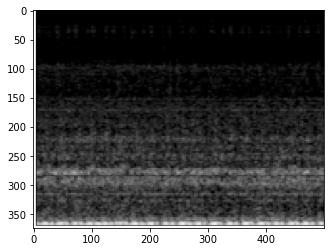

In [43]:
# Grayscale dosyasından rastgele bir görüntü seçip dönüşümü kontrol edelim
img1 = cv2.imread('grayscale/5/15544-5-0-18.png')
plt.imshow(img1)
plt.show()

In [44]:
# Grayscale dosyasından rastgele bir kaç görüntü alıp boyutlarına bakalım
import PIL # Görüntü işleme için kullanlır
im = PIL.Image.open('grayscale/1/100648-1-0-0.png')
print(im.size)

(500, 374)


In [45]:
im = PIL.Image.open('grayscale/8/102871-8-0-2.png')
print(im.size)

(500, 374)


In [46]:
im = PIL.Image.open('grayscale/5/103249-5-0-10.png')
print(im.size)

(500, 374)


In [47]:
feature = []
label = []

def parser(row):
    # Dosyaları yükleme ve özelliklerini çıkarma 
    for i in range(8732):
        file_name = 'fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        # kaiser_fast daha hızlı bir tekniktir
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
        feature.append(mels)
        label.append(df["classID"][i])
    return [feature, label]

In [48]:
temp = parser(df)

In [49]:
temp = np.array(temp)
data = temp.transpose()

In [50]:
X_ = data[:, 0]
y = data[:, 1]
print(X_.shape, y.shape)
X = np.empty([8732, 128])

(8732,) (8732,)


In [51]:
for i in range(8732):
    X[i] = (X_[i])

In [52]:
from tensorflow.keras.utils import to_categorical # Bir sayısal dizi veya farklı kategorileri temsil eden tamsayılara sahip bir vektör
y = to_categorical(y)

In [53]:
print(X.shape)
print(y.shape)

(8732, 128)
(8732, 10)


In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [55]:
X_train.shape

(6549, 128)

In [56]:
X_test.shape

(2183, 128)

In [57]:
X_train = X_train.reshape(6549, 16, 8, 1)
X_test = X_test.reshape(2183, 16, 8, 1)

<a id = "3"></a><br>
# 3.Model Hazırlanması ve Eğitimi

In [58]:
import tensorflow as tf # Bir derin öğrenme kütüphanesi

# Bir model nesnesi oluşturalım
model = tf.keras.Sequential()

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout

# Bir convolution ve  max pooling layer ekleyelim
model.add(Conv2D(32,kernel_size= (3, 3), padding = "same", activation = "relu", input_shape = (16,8,1)))
model.add(MaxPool2D(pool_size=(2, 2)))

In [60]:
model.add(Conv2D(64, kernel_size=(3, 3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.5))

In [61]:
# Flatten the convolution layer
model.add(Flatten())

In [62]:
# Çıktı katmanı ekleyelim
model.add(Dense(10, activation = "softmax"))

In [63]:
# Modeli derleyelim
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [64]:
results=model.fit(X_train, y_train, epochs = 50, batch_size = 128, validation_data = (X_test, y_test))

Epoch 1/50
52/52 [==============================] - 6s 17ms/step - loss: 2.8285 - accuracy: 0.2112 - val_loss: 2.0838 - val_accuracy: 0.3197
Epoch 2/50
52/52 [==============================] - 1s 19ms/step - loss: 2.1179 - accuracy: 0.2947 - val_loss: 1.9762 - val_accuracy: 0.3596
Epoch 3/50
52/52 [==============================] - 1s 21ms/step - loss: 2.0127 - accuracy: 0.3188 - val_loss: 1.9472 - val_accuracy: 0.3642
Epoch 4/50
52/52 [==============================] - 1s 22ms/step - loss: 1.9757 - accuracy: 0.3318 - val_loss: 1.8784 - val_accuracy: 0.3756
Epoch 5/50
52/52 [==============================] - 1s 21ms/step - loss: 1.9408 - accuracy: 0.3407 - val_loss: 1.8395 - val_accuracy: 0.4068
Epoch 6/50
52/52 [==============================] - 1s 21ms/step - loss: 1.8511 - accuracy: 0.3811 - val_loss: 1.7778 - val_accuracy: 0.4269
Epoch 7/50
52/52 [==============================] - 1s 21ms/step - loss: 1.7775 - accuracy: 0.4005 - val_loss: 1.7014 - val_accuracy: 0.4498
Epoch 8/50
52

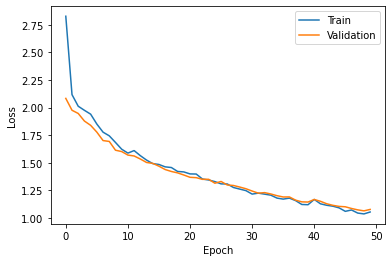

In [65]:
# Training kaybını görselleştirelim
plt.plot(results.history["loss"],label="Train")

# Validation kaybını görselleştirelim
plt.plot(results.history["val_loss"],label="Validation")

# x ve y eksenlerini adlandıralım
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()

plt.show()

In [66]:
# Performansı değerlendirelim
model.evaluate(X_test,y_test)

69/69 [==============================] - 0s 4ms/step - loss: 1.0773 - accuracy: 0.6748


[1.0772531032562256, 0.6747595071792603]

In [67]:
# Yeniden şekillendirilmiş örnek üzerinde tahminde bulunalım
predictions = model.predict(X_test)
score = model.evaluate(X_test, y_test)
print(score)

69/69 [==============================] - 0s 4ms/step - loss: 1.0773 - accuracy: 0.6748
[1.0772531032562256, 0.6747595071792603]
